# **Introduction**

Through this notebook today we will be trying to implement a classification model to classify pictures types of Pokemons into their respective classes. 

For the purpose of this project we have considered only 5 classes, i.e. by the end of this project our model will be able to identify the pokemon from these 5 classes given any kind of picture as the input.


---


> You will see the **keyword `None`** in certain places. 

These are the regions where you have to write your code. We will walk through the entire notebook together.

## Importing required libraries and packages.





In [48]:
import os 
#This module provides a portable way of using operating system dependent functionality. Such as finding the paths, opening and closing files and reading and writing them

import matplotlib.pyplot as plt
#Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python. We will use matplotlib to plot graphs and find relationships between variables

import numpy as np
#The fundamental package for scientific computing with Python. We will use numpy for mathematical computations and storing of data in arrays 

import seaborn as sns
#The fundamental package for scientific computing with Python


#for the purposes of this project we will be using Pytorch for all ML related operation such as building the model, transforming the images, spliting and everything
import torch
import torch.nn as nn                              #parent class for all layers that are used to build the model
import torch.optim as optim                        #is a package implementing various optimization algorithms
import torchvision                                 #The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision.
import torchvision.models as models                #contains definitions for different models to be used when implementing Transfer Learning
import torchvision.transforms as transforms        #used for image transformations
from torch.utils.data import random_split          #splitting the data
from torch.utils.data.dataloader import DataLoader #DataLoader wraps an iterable around the Dataset to enable easy access to the samples.
from torchvision.utils import make_grid            #make_grid role is to the several images into a single image.

#additional packages
import time
import PIL.Image as Image
from IPython.display import display

## Check if GPU is available

Before moving forward we will first find whether we have a GPU available in the system or not. 

GPU enables us to have greater computational power because of it enables us to run multiple processes simultaneously or conduct parallel processing, which makes certain tasks faster. Hence, to check whether we have a GPU or not we will use Pytorch's device function.

The typical GPU device is called **cuda:0**

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # if GPU not available use CPU
print(device)


cuda:0


# **Preprocessing**

**Quick look at the classes**

Before moving forward we must first understand how our files are stored in the directory. Our parent directory is called dataset, dataset contains **5 folders** divided according to the **5 classes** we are trying to classify into.


---


### **Steps for this code block:**

1. Our root path will be **to the root dataset inside "Pokemon-5Class-dataset"**

2. List the classes using **os.listdir( *path_to_your_root_folder* )**
3. Sort the classes using the mentioned **sorted()** function.
3. Print length of classes using **len(classes)** and print the classes

In [7]:
root_path = 'Pokemon-5Class-dataset/dataset'
classes = sorted(os.listdir(root_path))     # we are using os library to access the files in the folder
print( len(classes) , classes)                 # here we are printing the classes we will classify the images into

5 ['bulbasaur', 'charmander', 'mewtwo', 'pikachu', 'squirtle']


## Visualizing the data and check for balance/imbalance

### **Steps for this code block:**

1. Form **`dir_path`** (directory path) by joining **`root_path`** and each **`pokemon`** folder name. Use **`os.path.join(... , ...)`** 
2. To count total number of pokemons, keep adding the length of list of directores to count.  
3. Use **`os.listdir(path_name)`** for listing directorires. Use **`len()`** for finidng length
4. Print total number of images. *Hint: Count saves the length of all folders.*

5. Initialise matplotlib **`fig`** as **`plt.figure`** with **`figsize = (30, 10)`**
6. Set the axes and the title lineplot. Use list of **`(count_dict.keys())`** for x axis, list of **`(count_dict.values())`** for y axis). Set_title as **`'Number of images for each pokemon'`**

Total number of pokemons: 5
Total number of images: 1167


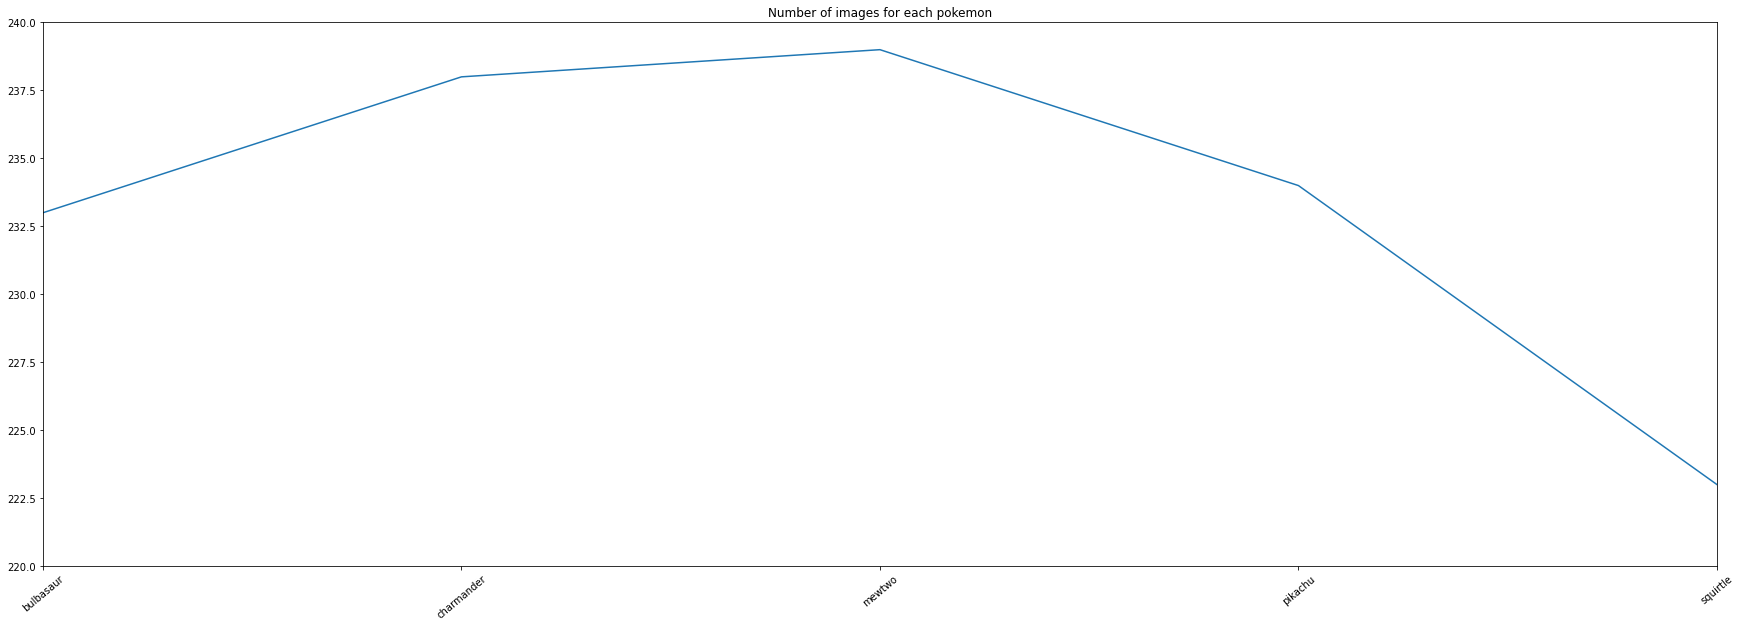

In [8]:
# here we have implemented a simple for loop to count the number of images we have for each class and then we plot it using matplotlib's lineplot

count=0
count_dict = {} # dictionary for counting pokemons for each class

print(f'Total number of pokemons: {len(classes)}')  # total number of classes

for pokemon in classes:
    dir_path = os.path.join(root_path, pokemon)      # entering each pokemon directory bu joining root path and pokemon name
    count+= len(os.listdir(dir_path))          # Counting all images in all the 5 folders
    count_dict[pokemon] = len(os.listdir(dir_path)) # saving number of pictures in each pokemon in the disctionary

print(f'Total number of images: {count}')


# Plotting the distribution of data

fig = plt.figure(figsize = (30, 10)) # set figure size
sns.lineplot(x = list(count_dict.keys()), y = list(count_dict.values())).set_title('Number of images for each pokemon')  # set x-axis, y-axis and title
plt.xticks(rotation = 40) # rotating the x labels for aesthetic purposes and for aking it more legible
plt.margins(x=0)
plt.ylim(220,240)  # set y axis range
plt.show()

Number of images in each class not vary much. Therefore, we conclude data is fairly balanced.

## Number of pokemon images in each class

### **Steps for this code block:**

1. Sort items of **`count_dict`** with the key lambda item: item[1] (as we are sorting the values of the dictionary taking position 1)  and **`reverse=True`**.

    Typical declaration of sorted: **`sorted(list_or_disctionary_name, key= lambda function, reverse=False)`**


In [12]:
sorted_list =  sorted(count_dict.items(), key=lambda item: item[1], reverse=True) # sorting count_dict.items() with key in reverse order
sorted_list

[('mewtwo', 239),
 ('charmander', 238),
 ('pikachu', 234),
 ('bulbasaur', 233),
 ('squirtle', 223)]

## **Load the data and transform**

Transformation of the images is a critical step in any image based ML model. Fot this, we are going to use ***PyTorch's transforms class*** which has the function **Compose**, which allows us to apply multiple transformation in a single line. 

In the given example, we are first resizing all the images to be ***400px wide and 400px high.*** The we are applying **Random Horizontal Flips** and **Random Rotations** to apply a special concept called as **Data Augmentation.**

> Data Augmentation is a process which allows us to make more the data look similar to real world data, In order for our model to train on more images and to work in every scenario we add transformations.


---


### **Steps for this code block:**

1. Use **`transforms.resize()`** to resize the image to **`(400,400)`**
2. Use **`transforms.RandomHorizontalFlip()`** to flip the image horizontally
3. Use **`transforms.RandomRotation()`** to randomly rotate the image my **15** degrees
4. Normalise the tensor so that it’s mean  and standard deviation are set to the value we specify. **Set Mean as 0.5 and Std as 0.5.** As there are 3 channels, each will be a tuple containing 3 values like **`(0.5, 0.5, 0.5)`**.
    
    Normalize function declaration: **`transforms.Normalize((mean, mean, mean), (std,std,std))`** 



In [10]:
dataset_dir = root_path

tfms = transforms.Compose([transforms.Resize((400,400)),
                                 transforms.RandomHorizontalFlip(),               # Horizontal flip
                                 transforms.RandomRotation(15),               # Random Rotation by 15 degrees
                                 transforms.ToTensor(), # convert image to tensor
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])               # Normalise the tensor

Forming dataset containing image and target label using ImageFolder.

In [17]:
dataset = torchvision.datasets.ImageFolder(root=dataset_dir, transform = tfms)

Check one image to see how tranformations have been applied and whether our dataset is set for model training.

**`torch.permute()`** rearranges the original tensor according to the desired ordering. We use it as PyTorch Tensors ("Image tensors") are channel first, so to use them with matplotlib you need to **reshape it to channel last**( hence 1,2,0).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 400, 400])
Label (numeric): 0
Label (textual): bulbasaur


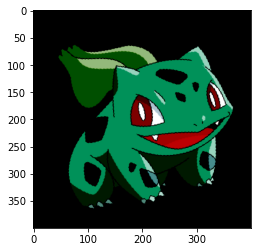

In [18]:
img, label = dataset[0]  # Taking a single instance
print(img.shape)         # print shape
plt.imshow(img.permute((1, 2, 0))) # plot image
print('Label (numeric):', label)
print('Label (textual):', classes[label])

In [19]:
torch.manual_seed(100) # we add a manual seed so that when we are randomly splitting the data, regardless of how many times we run it the split will remain the same

# **Splitting the dataset**

We split our data into two parts, the training data and the validation data. The training data is the actual data on which the model is trained, validation dataset, is the set on which we check the accuracy of the dataset. 

Any common ML model will always be composed of these two datasets and a testing dataset, which is not touched or exposed to the ML model till the end, when we make the final predictions. 

The primary goal of using a validation dataset is to find the accuracy of the model without leading to any data leakages.

**Spliting our data for training and testing, in the ratio 90% and 10% resp.**


In [20]:
train_size = int(len(dataset)*0.90)  # 90% training
val_size = int(len(dataset)*0.10) + 1  # we add 1 as division was not whole number. 
print(train_size)
print(val_size)

1049
117


**Random Split**

Pytorch's random_split enables us to split the data randomly so that there is no kind of data leakage due to the order of the data in which we provide. Since, we set the random seed to be a constant value in the starting, everytime the following cell is executed we will get the same split which enables us to debug and check the model performance easily.

In [21]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])  #randomly split the dataset
len(train_ds), len(val_ds)

(1049, 117)

## **Steps for this code block:**

1. Set batch size as **`32`**, shuffle as **`True`**, num_workers as **`2`** for trainloader
2. Set batch size as **`32`**, shuffle as **`False`**, num_workers as **`2`** for testloader

In [23]:
trainloader = DataLoader(train_ds, batch_size = 32, shuffle=True, num_workers = 2)
testloader = DataLoader(val_ds, batch_size = 32, shuffle=False, num_workers = 2)

### Check images loaded in a single batch

images.shape: torch.Size([32, 3, 400, 400])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


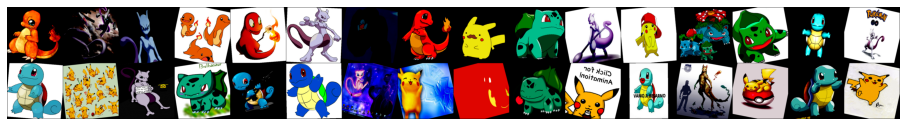

In [24]:
for images, _ in trainloader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8)) # setting figure size
    plt.axis('off')   # we do not was x-ticks and y-ticks
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0))) # 16 images in a row
    break

# **Modelling**

Defining the function which will train our model. Despite the fact that the model looks very complex and scary, in reality its only taking the data, running the model and then finds the loss and accuracies

Dataloader returns a tuple with the current batch zero-based index value, and the actual batch of data. Thus we use i and data as the iterator in the training loop.

---


### **Steps for this code block:**

1. Set range as **`n_epochs`**. Use **"epoch"** as the itarator for the loop.
2. Load inputs and labels to your device (CPU or GPU). Example: loading x to device is done using x=x.to(device)
3. Save output of model by sending inputs to your model as parameter. Example: myoutput=mynetwork(mydata)
4. Find loss using function criterion(..., ...) sending output and labels as parameters
5. Backpropagate using loss.backward()
6. Call optimizer using optimizer.step()

In [43]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    
    # relevant list declaration
    
    losses = []
    accuracies = []
    test_accuracies = []



    # set the model to train mode initially
    model.train()
    for epoch in range(n_epochs):

        since = time.time()  # starting timer

        running_loss = 0.0
        running_correct = 0.0


        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize

            outputs = model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)  # The higher the energy for a class, the more the network thinks that the image is of the particular class. We the index of the highest energy
            
            loss = criterion(outputs,labels)
            loss.backward()  #backpropagation to change weights and biases
            optimizer.step() #optimizer
            
            # calculate the loss/acc later

            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since # total time for an epoch

        epoch_loss = running_loss/len(trainloader)
        epoch_acc = 100/32*running_correct/len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc)) # Printing accuracy loss duration for each epoch
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data

        model.eval() # change to evaluation mode
        test_acc = eval_model(model) # function described after this block
        test_accuracies.append(test_acc)
        
        # reset the model to train mode after validating

        model.train()
        scheduler.step(test_acc) # schedulaer discussed bellowed. Parameter sent is valid_loss/len(validloader)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

This function is called out after each epoch of training on the training data. We then measure the accuracy of the model.

1. **`model.eval()`** will notify all your layers that you are in eval mode, that way, batchnorm or dropout layers will work in eval mode instead of training mode.
2. **torch.no_grad()** impacts the autograd engine and deactivate it. It will reduce memory usage and speed up computations but you won’t be able to backprop (which you don’t want in an eval script).



---


### **Steps for this code block:**

1. Apply torch.no_grad() before the for loop.
2. Load inputs and labels to your device (CPU or GPU). Example: loading x to device is done using x=x.to(device)
3. Save output of model by sending inputs to your model as parameter. Example: myoutput=mynetwork(mydata)

In [44]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0) # calculating total number of labels
            correct += (predicted == labels).sum().item() # calculating correct evalutation

    test_acc = (float)(100.00 * (correct / total))
    print('Accuracy of the network on the test images: %.4f' % (
        test_acc))
    return test_acc

## Creating the Network


---


### **Steps for this code block:**

1. For conv1 set Conv2d with 3 input image channel, 6 output channels, 5x5 square convolution kernel
2. For pool set MaxPool2d with kernel_size 2 and stride 2
2. For conv2 set Conv2d with 6 input image channel, 16 output channels, 5x5 square convolution kernel

In [54]:
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 97 * 97, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # check shape
        print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #check shape
        print(x.shape)

        
        x = torch.flatten(x, 1) # flatten all dimensions except batch for dense layers 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

#here we have designed a class which contains the layers of the model we are building.
#designing a class helps us in making our code modular and also allows us to import the code for our future use

### **Steps for this code block:**

1. Set Loss (criterion as Cross Entropy Loss
2. Set optimizer To SGD with learning rate = 0.001 and momentum=0.9

In [55]:
model_ft = net.to(device)

criterion = nn.CrossEntropyLoss()
# EG. optimizer = optim.Adam(model_ft.parameters(),lr = 0.0001) 
optimizer = optim.SGD(model_ft.parameters(),lr = 0.001, momentum = 0.9) 
# lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.8)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

## Train Your Model

In [65]:
#here we are using the above designed function to train our model on the training data and saving the training losses and accuracies in a seperate variables
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=3)

torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])


/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97

/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([25, 6, 198, 198])
torch.Size([25, 16, 97, 97])
Epoch 1, duration: 35 s, loss: 0.5079, acc: 82.8598
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([21, 6, 198, 198])
torch.Size([21, 16, 97, 97])
Accuracy of the network on the test images: 88.8889
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size(

/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])


/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([25, 6, 198, 198])
torch.Size([25, 16, 97, 97])
Epoch 2, duration: 36 s, loss: 0.4346, acc: 84.0909
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([21, 6, 198, 198])
torch.Size([21, 16, 97, 97])
Accuracy of the network on the test images: 88.0342


/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])


/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97

In [60]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=5)

/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97

KeyboardInterrupt: 

## Plotting the losses and the accuracy of our model over the epochs

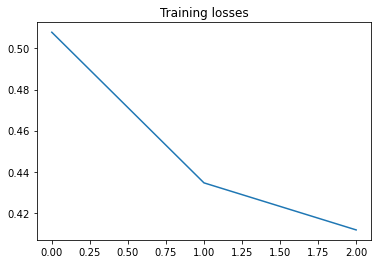

In [67]:
plt.title('Training losses')
plt.plot(training_losses)

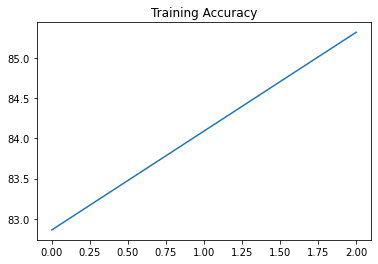

In [68]:
plt.title('Training Accuracy')
plt.plot(training_accs)

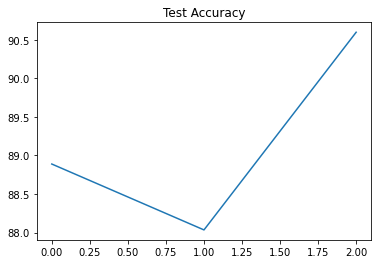

In [69]:
plt.title('Test Accuracy')
plt.plot(test_accs)

## Save your model

In [70]:
torch.save(model_ft, "./simplecnn_model.pt") #here we save the model parameters and hyperparameters so that we can use them in the future without actually training it again

**Evaluate the model on never seen before images.**

In [71]:
# switch the model to evaluation mode to make dropout and batch norm work in eval mode
model_ft.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=150544, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)

Here is the most important part of any ML project, here we will be now using the model to make predictions on data which it has never seen before and we will print the confidence values as well

torch.Size([1, 6, 198, 198])
torch.Size([1, 16, 97, 97])


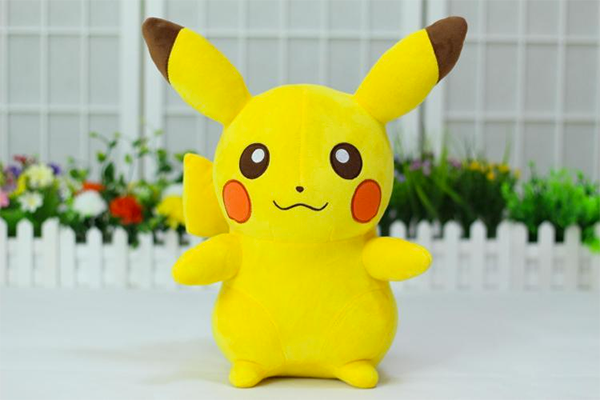

pikachu confidence:  7.71580171585083
torch.Size([1, 6, 198, 198])
torch.Size([1, 16, 97, 97])


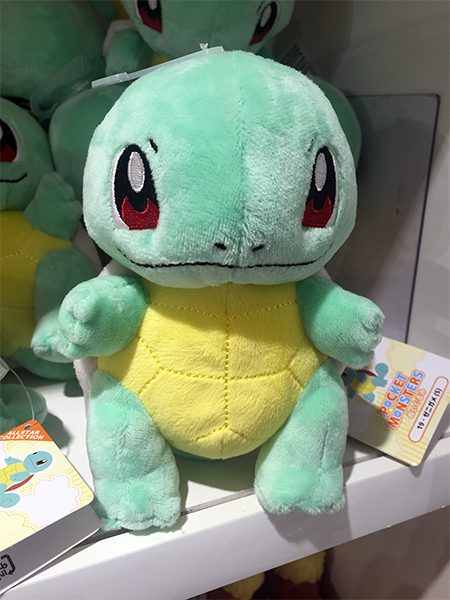

squirtle confidence:  3.2366786003112793
torch.Size([1, 6, 198, 198])
torch.Size([1, 16, 97, 97])


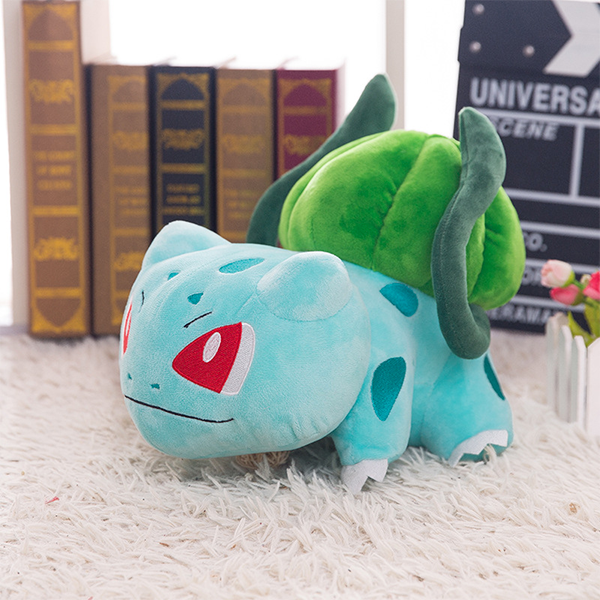

bulbasaur confidence:  4.889058589935303
torch.Size([1, 6, 198, 198])
torch.Size([1, 16, 97, 97])


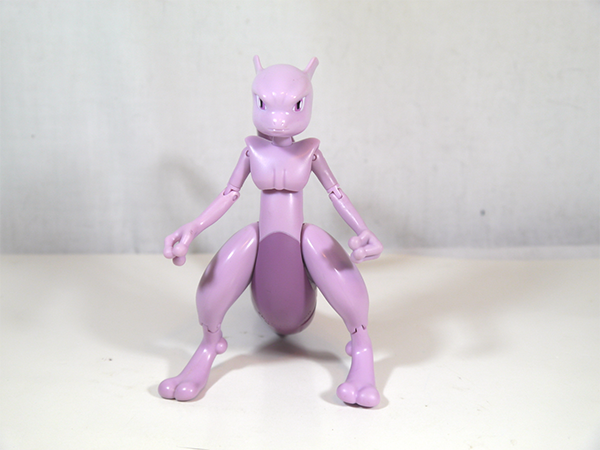

mewtwo confidence:  2.997398614883423


In [72]:
test_imgs = ['pikachu_toy.png','squirtle_plush.png', 'bulbasaur_plush.png', 'mewtwo_toy.png']

# transforms for the input image
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

for img in test_imgs:
    test_img_path = 'Pokemon-5Class-dataset/Test_images/'+ img
    image = Image.open(test_img_path).convert('RGB')
    image = loader(image).float()
    image = torch.autograd.Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    image = image.cuda()
    output = model_ft(image)
    conf, predicted = torch.max(output.data, 1)

    display(Image.open(test_img_path))
    print(classes[predicted.item()], "confidence: ", conf.item())

# **EXTRA - Transfer Learning**

Transfer learning is a very special and important concept which allows us to use pre-trained models for our projects. So, in this case we have imporated a pre-trained Resnet model and with the help of the model we are making predictions on the same test set.

In [73]:
model_resft = models.resnet34(pretrained=True) #imporating resnet model
num_resftrs = model_resft.fc.in_features

model_resft.fc = nn.Linear(num_resftrs, 5) #No. of classes = 5
model_resft = model_resft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:


model_resft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=15)




/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97

/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97

/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])


/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97

/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97

/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])


/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([25, 6, 198, 198])
torch.Size([25, 16, 97, 97

/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])


/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([25, 6, 198, 198])
torch.Size([25, 16, 97, 97])
Epoch 6, duration: 35 s, loss: 0.2755, acc: 89.7727
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torc

/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97

/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([25, 6, 198, 198])
torch.Size([25, 16, 97, 97])
Epoch 7, duration: 35 s, loss: 0.2562, acc: 90.6250
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([21, 6, 198, 198])
torch.Size([21, 16, 97, 97])
Accuracy of the network on the test images: 94.0171
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size(

/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])


/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([25, 6, 198, 198])
torch.Size([25, 16, 97, 97])
Epoch 8, duration: 35 s, loss: 0.2434, acc: 91.6667
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([21, 6, 198, 198])
torch.Size([21, 16, 97, 97])
Accuracy of the network on the test images: 94.0171
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])


/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])


/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([25, 6, 198, 198])
torch.Size([25, 16, 97, 97])
Epoch 9, duration: 35 s, loss: 0.2496, acc: 91.5720
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torc

/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])


/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97

/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97

/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([25, 6, 198, 198])
torch.Size([25, 16, 97, 97])
Epoch 11, duration: 35 s, loss: 0.2479, acc: 90.7197
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
tor

/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97

/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([25, 6, 198, 198])
torch.Size([25, 16, 97, 97])
Epoch 12, duration: 34 s, loss: 0.2446, acc: 91.0038
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([21, 6, 198, 198])
torch.Size([21, 16, 97, 97])
Accuracy of the network on the test images: 92.3077
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])


/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])


/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97

/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])


/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97

/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97])
torch.Size([32, 6, 198, 198])
torch.Size([32, 16, 97, 97

We will again plot the losses and the accuracy and we can see that the Resnet model performed better

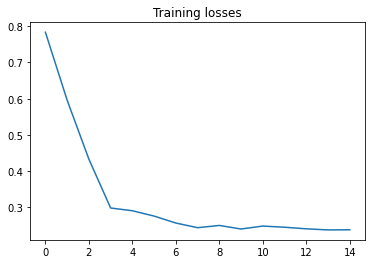

In [ ]:
plt.title('Training losses')
plt.plot(training_losses)


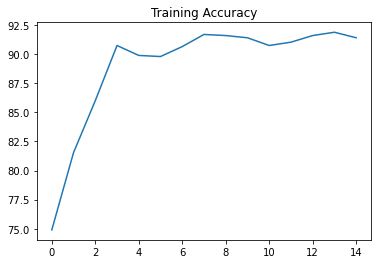

In [ ]:

plt.title('Training Accuracy')
plt.plot(training_accs)


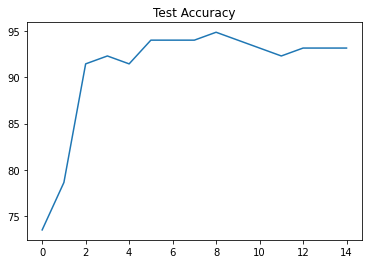

In [ ]:

plt.title('Test Accuracy')
plt.plot(test_accs)

In [ ]:
test_imgs = ['pikachu_toy.png','squirtle_plush.png', 'bulbasaur_plush.png', 'mewtwo_toy.png']

# transforms for the input image
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

for img in test_imgs:
    test_img_path = 'Pokemon-5Class-dataset/Test_images/'+ img
    image = Image.open(test_img_path).convert('RGB')
    image = loader(image).float()
    image = torch.autograd.Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    image = image.cuda()
    output = model_resft(image)
    conf, predicted = torch.max(output.data, 1)

    display(Image.open(test_img_path))
    print(classes[predicted.item()], "confidence: ", conf.item())

## Example for a ResNet Block

In [ ]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x 
    
